## Image Preprocess

In [1]:
# !du -ah ~ | sort -rh | head -20

In [2]:
# rm -rf ~/anaconda3/pkgs/*

In [3]:
import json
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [127]:
# Create Label Mapping
def create_label_mappings(annotation_files):
    logo_name_to_label = {}
    label_to_logo_name = {}
    current_label = 0
    
    for annotation_file in annotation_files:
        with open(annotation_file, 'r') as f:
            annotations = json.load(f)
            
            for product_image, details in annotations.items():
                for _, logo_image_name in details:
                    base_logo_name = logo_image_name.split('-')[0]  # Use base name for mapping (e.g., 'skechers')
                    
                    # Filter out unknown logos
                    if base_logo_name == '__unknown__' or logo_image_name == '__unknown__':
                        continue  # Skip this entry
                    
                    if base_logo_name not in logo_name_to_label:
                        # Assign a unique label to the base logo name
                        logo_name_to_label[base_logo_name] = current_label
                        label_to_logo_name[current_label] = base_logo_name
                        current_label += 1

    return logo_name_to_label, label_to_logo_name

# Define paths to the annotation files
annotation_files = ["./annotations/osld-train.json", "./annotations/osld-test.json", "./annotations/osld-val.json"]

# Create mappings
logo_name_to_label, label_to_logo_name = create_label_mappings(annotation_files)

# Example usage: Print mappings
# print("Logo Name to Label Mapping:", logo_name_to_label)
# print("Label to Logo Name Mapping:", label_to_logo_name)

In [5]:
len(logo_name_to_label)

5143

In [6]:
import json

def check_unique_images_and_brands(annotation_file, logo_name_to_label):
    unique_images = set()
    unique_brands = set()
    unknown_images = 0  # Counter for images labeled as "__unknown__"
    
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
        
        # Iterate through each product's annotations in the JSON file
        for product_image, details in annotations.items():
            for _, logo_image_name in details:
                # Get the base logo name (brand)
                base_logo_name = logo_image_name.split('-')[0]
                
                # If the label is "__unknown__", increment the counter
                if base_logo_name == "__unknown__":
                    unknown_images += 1
                
                # Add the image name and the base logo to the sets
                unique_images.add(product_image)
                unique_brands.add(base_logo_name)
                
    # Return the number of unique images, unique brands, and __unknown__ images
    return len(unique_images), len(unique_brands), unknown_images

# Example usage
train_unique_images, train_unique_brands, train_unknown_images = check_unique_images_and_brands("./annotations/osld-train.json", logo_name_to_label)
val_unique_images, val_unique_brands, val_unknown_images = check_unique_images_and_brands("./annotations/osld-val.json", logo_name_to_label)
test_unique_images, test_unique_brands, test_unknown_images = check_unique_images_and_brands("./annotations/osld-test.json", logo_name_to_label)

# Print the results
print(f"Unique images in the train dataset: {train_unique_images}")
print(f"Unique brands in the train dataset: {train_unique_brands}")
print(f"Images labeled '__unknown__' in the train dataset: {train_unknown_images}")
print(f"Unique images in the val dataset: {val_unique_images}")
print(f"Unique brands in the val dataset: {val_unique_brands}")
print(f"Images labeled '__unknown__' in the val dataset: {val_unknown_images}")
print(f"Unique images in the test dataset: {test_unique_images}")
print(f"Unique brands in the test dataset: {test_unique_brands}")
print(f"Images labeled '__unknown__' in the test dataset: {test_unknown_images}")

Unique images in the train dataset: 15445
Unique brands in the train dataset: 4144
Images labeled '__unknown__' in the train dataset: 8022
Unique images in the val dataset: 1642
Unique brands in the val dataset: 501
Images labeled '__unknown__' in the val dataset: 211
Unique images in the test dataset: 2233
Unique brands in the test dataset: 501
Images labeled '__unknown__' in the test dataset: 648


In [7]:
# def resize_with_padding(img, target_size=(224, 224)):
#     """Resize an image while maintaining its aspect ratio and padding to fit the target size."""
#     old_size = img.size  # (width, height)
    
#     # Calculate the ratio and new size
#     ratio = float(target_size[0]) / max(old_size)
#     new_size = tuple(int(x * ratio) for x in old_size)

#     # Resize the image using LANCZOS filter
#     img = img.resize(new_size, Image.LANCZOS)

#     # Create a new image with the target size and a black background
#     new_image = Image.new("RGB", target_size)

#     # Calculate the position to paste the resized image onto the new image
#     paste_x = (target_size[0] - new_size[0]) // 2
#     paste_y = (target_size[1] - new_size[1]) // 2

#     # Paste the resized image onto the new image
#     new_image.paste(img, (paste_x, paste_y))

#     return new_image

In [8]:
import re
import json
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class LogoDataset(Dataset):
    def __init__(self, image_directory, annotation_file, logo_name_to_label, target_size=(224, 224), transform=None):
        self.image_directory = image_directory
        self.target_size = target_size
        self.transform = transform  # Allow for additional transformations
        self.logo_name_to_label = logo_name_to_label  # Use the passed label mapping
        self.images = []
        self.labels = []
        self.load_data(annotation_file)

    def load_data(self, annotation_file):
        with open(annotation_file, 'r') as f:
            annotations = json.load(f)
            for product_image, details in annotations.items():
                for region, logo_image_name in details:
                    base_logo_name = logo_image_name.split('-')[0]  # Extract the base logo name
                    
                    # Skip unknown logos
                    if base_logo_name == '__unknown__' or logo_image_name == '__unknown__':
                        continue
                    
                    # Create a data point for each valid logo region
                    self.images.append((product_image, region))  # Store image name and bounding box
                    # Use the logo_name_to_label mapping to get the integer label
                    self.labels.append(self.logo_name_to_label[base_logo_name])  # Store the label as an integer

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Extract image name and bounding box for the region
        image_name, region = self.images[idx]
        image_path = os.path.join(self.image_directory, image_name)

        # Load the image
        image = Image.open(image_path)
        
        # Crop the image based on the bounding box
        cropped_image = self.crop_image(image, region)
        
        # Resize the image to the target size
        cropped_image = self.resize_without_padding(cropped_image, self.target_size)
        
        # Apply transformations if provided
        if self.transform:
            cropped_image = self.transform(cropped_image)
        else:
            cropped_image = transforms.ToTensor()(cropped_image)  # Convert to tensor if no transform is provided
        
        # Fetch the label for the current region (integer label)
        label = self.labels[idx]
        return cropped_image, label

    def crop_image(self, image, bbox):
        """Crop the image based on bounding box."""
        x1, y1, x2, y2 = bbox
        return image.crop((x1, y1, x2, y2))

    def resize_without_padding(self, img, target_size=(224, 224)):
        """Resize an image to the target size without maintaining aspect ratio or adding padding."""
        # Resize the image directly to the target size
        img = img.convert("RGB") 
        img = img.resize(target_size, Image.LANCZOS)
        return img


    # def resize_with_padding(self, img, target_size=(224, 224)):
    #     """Resize an image while maintaining its aspect ratio and padding to fit the target size."""
    #     old_size = img.size  # (width, height)
        
    #     # Calculate the ratio and new size
    #     ratio = float(target_size[0]) / max(old_size)
    #     new_size = tuple(int(x * ratio) for x in old_size)

    #     # Resize the image using LANCZOS filter
    #     img = img.resize(new_size, Image.Resampling.LANCZOS)  # Use LANCZOS filter (updated for Pillow >= 10.0)

    #     # Create a new image with the target size and a white background (255, 255, 255)
    #     new_image = Image.new("RGB", target_size, (0, 0, 0))  # Black padding
        
    #     # Calculate the position to paste the resized image onto the new image
    #     paste_x = (target_size[0] - new_size[0]) // 2
    #     paste_y = (target_size[1] - new_size[1]) // 2

    #     # Paste the resized image onto the new image
    #     new_image.paste(img, (paste_x, paste_y))

    #     return new_image


In [9]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to a fixed size
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally,
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.RandomGrayscale(p=0.1),  # Randomly convert to grayscale with 10% probability
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])


In [10]:
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize the image to a fixed size
#     transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
#     transforms.RandomRotation(30),  # Randomly rotate images
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
#     transforms.RandomGrayscale(p=0.1),  # Randomly convert to grayscale with 10% probability
#     transforms.Lambda(lambda x: x.convert("RGB") if x.mode != "RGB" else x),  # Ensure 3-channel images
#     transforms.ToTensor(),  # Convert PIL image to tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
# ])

In [33]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Path to your image directory and annotation file
image_directory = './product-images'
annotation_file = './annotations/osld-train.json'

# Define your dataset
train_dataset = LogoDataset(
    image_directory=image_directory,
    annotation_file=annotation_file,
    logo_name_to_label=logo_name_to_label,
    target_size=(224, 224),  # Resize to 224x224
    transform=transform  # Apply the transformations
)

# Create DataLoader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

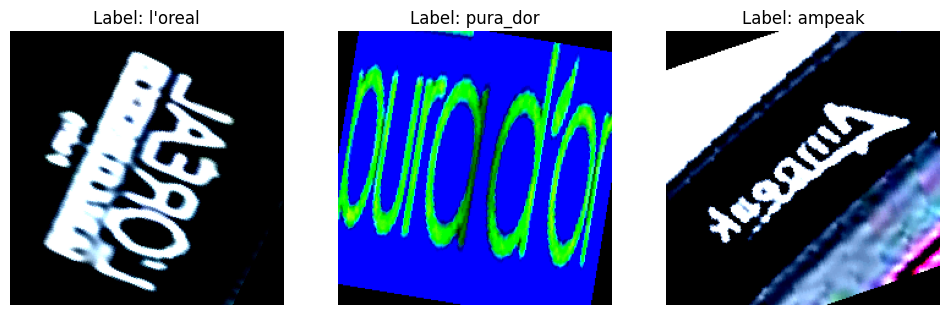

In [34]:
# Function to convert a tensor to a NumPy array for visualization
def tensor_to_numpy(image_tensor):
    image_tensor = image_tensor.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    image_tensor = image_tensor.numpy()  # Convert to NumPy
    image_tensor = np.clip(image_tensor, 0, 1)  # Ensure the values are between 0 and 1 for display
    return image_tensor

# Display a couple of images with labels
for images, labels in train_loader:
    # Display first 3 images in the batch
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    for i in range(3):
        ax = axes[i]
        image = tensor_to_numpy(images[i])  # Convert tensor to NumPy
        label = labels[i].item()  # Get the label (assuming labels are integer values)
        label_name = list(logo_name_to_label.keys())[list(logo_name_to_label.values()).index(label)]  # Get the logo name
        
        ax.imshow(image)
        ax.set_title(f"Label: {label_name}")  # Show the label name
        ax.axis('off')  # Turn off axis for a clean view
    
    plt.show()
    break  # Just showing the first batch for demonstration

In [35]:
annotation_file = './annotations/osld-test.json'

# Define your dataset
test_dataset = LogoDataset(
    image_directory=image_directory,
    annotation_file=annotation_file,
    logo_name_to_label=logo_name_to_label,
    target_size=(224, 224),  # Resize to 224x224
    transform=transform  # Apply the transformations
)

# Create DataLoader for batching and shuffling
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [36]:
annotation_file = './annotations/osld-val.json'

# Define your dataset
val_dataset = LogoDataset(
    image_directory=image_directory,
    annotation_file=annotation_file,
    logo_name_to_label=logo_name_to_label,
    target_size=(224, 224),  # Resize to 224x224
    transform=transform  # Apply the transformations
)

# Create DataLoader for batching and shuffling
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [41]:
print(len(train_dataset), len(test_dataset), len(val_dataset))

11951 1709 3414


In [16]:
print(len(train_dataset) + len(test_dataset) + len(val_dataset))

17074


In [17]:
# # Combine train, val, and test datasets
# combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset, test_dataset])

# # Shuffle the combined dataset
# combined_loader = DataLoader(combined_dataset, shuffle=True, batch_size=32)

# # Calculate the size for the 80-20 split (80% train, 20% test)
# train_size = int(0.8 * len(combined_dataset))
# test_size = len(combined_dataset) - train_size

# # Split the combined dataset into 80-20
# train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

# # Now you can create DataLoader for both train and test sets
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [39]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets

# Assuming you already have the combined dataset (train + val + test)
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset, test_dataset])

# Calculate the sizes for the 70-20-10 split
train_size = int(0.7 * len(combined_dataset))
val_size = int(0.2 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - val_size

# Split the combined dataset into 70% train, 20% validation, 10% test
generator = torch.Generator().manual_seed(42)  # For reproducibility
train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size], generator=generator)

# Create DataLoader for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Optionally, print the sizes of the datasets
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 11951
Validation dataset size: 3414
Test dataset size: 1709


In [42]:
len(combined_dataset)

17074

In [20]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets

# Assuming train_dataset, val_dataset, and test_dataset are already defined
# Example for getting unique classes from a dataset

def get_unique_classes(dataset):
    # Get the class labels from the dataset (assuming each item in the dataset returns a (image, label) tuple)
    labels = [label for _, label in dataset]
    unique_labels = set(labels)  # Convert to set to get unique values
    return unique_labels

# Get and print unique class labels for each dataset
train_unique_classes = get_unique_classes(train_dataset)
val_unique_classes = get_unique_classes(val_dataset)
test_unique_classes = get_unique_classes(test_dataset)
combined_unique_classes = get_unique_classes(combined_dataset)

# Print the number of unique classes in each dataset
print(f"Unique classes in train dataset: {len(train_unique_classes)}")
print(f"Unique classes in validation dataset: {len(val_unique_classes)}")
print(f"Unique classes in test dataset: {len(test_unique_classes)}")
print(f"Unique classes in combined dataset: {len(combined_unique_classes)}")


Unique classes in train dataset: 4527
Unique classes in validation dataset: 2285
Unique classes in test dataset: 1349
Unique classes in combined dataset: 5143


In [21]:
from collections import Counter

def remove_classes_with_single_sample(dataset):
    labels = [label for _, label in dataset]
    class_count = Counter(labels)

    # Identify classes with only one sample
    classes_to_remove = {class_label for class_label, count in class_count.items() if count == 1}

    # Filter indices, ensuring they are within valid bounds
    filtered_indices = [
        idx for idx, (_, label) in enumerate(dataset)
        if label not in classes_to_remove and idx < len(dataset)
    ]

    if not filtered_indices:
        raise ValueError("Filtered dataset is empty. Check your data distribution.")

    return filtered_indices


# Get filtered indices
train_filtered_indices = remove_classes_with_single_sample(train_dataset)
# val_filtered_indices = remove_classes_with_single_sample(val_dataset)
# test_filtered_indices = remove_classes_with_single_sample(test_dataset)

In [57]:
# Filtered indices must align with the train_dataset split
train_filtered_indices = [
    idx for idx in train_dataset.indices if idx in train_filtered_indices
]

# Apply the filtered indices to create the subset
train_dataset_filtered = torch.utils.data.Subset(train_dataset.dataset, train_filtered_indices)

# Create a DataLoader for the filtered dataset
train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=32, shuffle=True)

print(f"Filtered Train dataset size: {len(train_dataset_filtered)}")


Filtered Train dataset size: 7158


In [55]:
# # Create filtered subsets using the indices
# train_dataset_filtered = torch.utils.data.Subset(train_dataset, train_filtered_indices)
# # val_dataset_filtered = torch.utils.data.Subset(val_dataset, val_filtered_indices)
# # test_dataset_filtered = torch.utils.data.Subset(test_dataset, test_filtered_indices)

# # Create DataLoaders for the filtered datasets
# train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=32, shuffle=True)
# # val_loader_filtered = DataLoader(val_dataset_filtered, batch_size=32, shuffle=False)
# # test_loader_filtered = DataLoader(test_dataset_filtered, batch_size=32, shuffle=False)

# # Print dataset sizes
# print(f"Filtered Train dataset size: {len(train_dataset_filtered)}")
# # print(f"Filtered Validation dataset size: {len(val_dataset_filtered)}")
# # print(f"Filtered Test dataset size: {len(test_dataset_filtered)}")

In [56]:
print(f"Total images in train_dataset: {len(train_dataset.indices)}")
print(f"Max index in filtered indices: {max(train_filtered_indices)}")
print(f"Min index in filtered indices: {min(train_filtered_indices)}")

Total images in train_dataset: 11951
Max index in filtered indices: 11950
Min index in filtered indices: 0


In [59]:
from collections import Counter
import torch
from torch.utils.data import WeightedRandomSampler, DataLoader

def calculate_sample_weights(dataloader):
    class_count = Counter()
    for _, label in dataloader:
        class_count.update(label.cpu().numpy())
    
    total_samples = sum(class_count.values())
    weights = {class_label: total_samples / count for class_label, count in class_count.items()}
    return weights

# Get weights per class
class_weights = calculate_sample_weights(train_loader_filtered)

# Map weights to dataset indices
sample_weights = [class_weights[train_dataset_filtered.dataset.labels[idx]] for idx in train_dataset_filtered.indices]

# Pass directly to WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)


AttributeError: 'ConcatDataset' object has no attribute 'labels'

In [60]:
from collections import Counter
import torch
from torch.utils.data import WeightedRandomSampler, DataLoader

# Function to calculate class distribution and weights
def check_class_distribution_from_dataloader(dataloader):
    class_count = Counter()
    for data, label in dataloader:
        class_count.update(label.cpu().numpy())  # Count occurrences of each label as we go
    
    total_samples = sum(class_count.values())

    # Calculate weights for each class (inverse of the frequency)
    weights = {class_label: total_samples / count for class_label, count in class_count.items()}
    
    # Create a list of sample weights based on labels
    sample_weights = []
    for data, label in dataloader:
        sample_weights.extend([weights[l] for l in label.cpu().numpy()])  # Get weights for each label in the batch

    return sample_weights, total_samples

# Calculate the sample weights using class distribution
sample_weights, total_samples = check_class_distribution_from_dataloader(train_loader_filtered)

# Use WeightedRandomSampler to sample with balanced weights
sampler = WeightedRandomSampler(sample_weights, num_samples=total_samples, replacement=True)

# Create DataLoader with WeightedRandomSampler for balanced batching
train_loader_balanced = DataLoader(train_dataset_filtered, batch_size=32, sampler=sampler)


In [ ]:
# from torch.utils.data import WeightedRandomSampler

# # Get labels for filtered dataset
# filtered_labels = [label for _, label in train_dataset_filtered]

# # Calculate class weights
# class_count = Counter(filtered_labels)
# total_samples = sum(class_count.values())
# class_weights = {label: total_samples / count for label, count in class_count.items()}

# # Assign weights to each sample
# sample_weights = [class_weights[label] for label in filtered_labels]

# # Create WeightedRandomSampler
# sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# # Create DataLoader with balanced sampling
# train_loader_balanced = DataLoader(train_dataset_filtered, batch_size=32, sampler=sampler)


In [ ]:
# Function to get unique brands (logos) in a dataset
def get_unique_brands_from_combined(dataset):
    unique_brands = set()
    for d in dataset.datasets:  # Iterate through the individual datasets in the combined dataset
        unique_brands.update(d.labels)  # Update with the labels from each individual dataset
    return unique_brands

# Get unique brands from the combined dataset
total_brands = get_unique_brands_from_combined(combined_dataset)

# Print the number of unique brands in the combined dataset
print(f"Number of unique brands in the combined dataset: {len(total_brands)}")

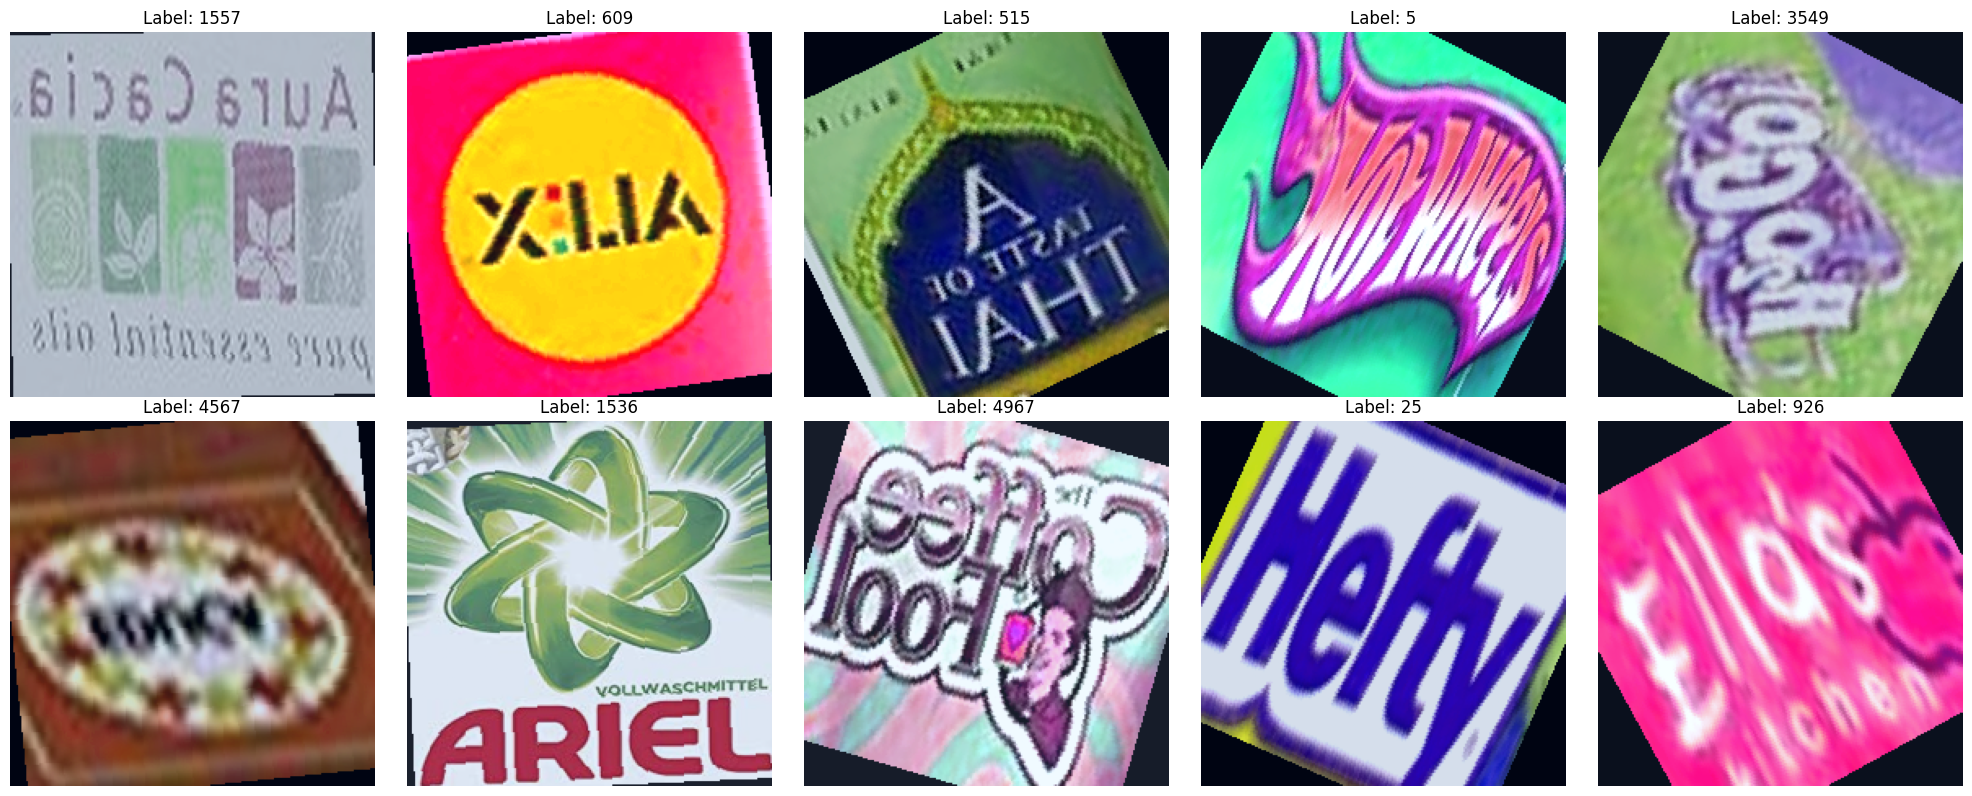

In [61]:
import matplotlib.pyplot as plt

# preview train_loader

# Get a batch of images and labels
batch_images, batch_labels = next(iter(train_loader_balanced))

# Display the first 10 images from the batch to check
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows and 5 columns
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i in range(10):
    img = batch_images[i].permute(1, 2, 0).numpy()  # Convert back to HWC format
    img = (img * 0.229 + 0.485).clip(0, 1)  # Unnormalize for display
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {batch_labels[i].item()}")
    axes[i].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [62]:
label_to_logo_name[609]

'alex_toys'

## Model Training

In [63]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from pytorch_metric_learning import losses
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ResNet50Embedding(nn.Module):
    def __init__(self, embedding_dim=256):
        super(ResNet50Embedding, self).__init__()
        
        # Load a pretrained ResNet-50 model
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Remove the final fully connected layer
        self.resnet.fc = nn.Identity()

        # Get the feature size from ResNet's output after passing through the convolutional layers
        dummy_input = torch.zeros(1, 3, 224, 224)  # A dummy input tensor of size [1, 3, 224, 224] (standard input size for ResNet)
        feature_size = self.resnet(dummy_input).shape[1]  # Get the feature size by passing the dummy input through ResNet

        # Add a new fully connected layer to increase capacity
        self.fc1 = nn.Linear(feature_size, 1024)  # Extra FC layer before embedding

        # The final embedding layer
        self.embedding_layer = nn.Linear(1024, embedding_dim)  # Final output embeddings

    def forward(self, x):
        # Forward pass through ResNet backbone (without the final FC layer)
        x = self.resnet(x)
        
        # Pass through extra fully connected layer
        x = self.fc1(x)
        
        # Apply ReLU activation after the FC layer
        x = F.relu(x)
        
        # Get the final embeddings
        x = self.embedding_layer(x)
        
        # Apply L2 Normalization on the embeddings
        x = F.normalize(x, p=2, dim=1)
        
        return x

In [ ]:
# import torch
# import torch.nn.functional as F

# def train(model, loss_func, device, train_loader, optimizer, scheduler, epoch, hard_negative_mining=False):
#     model.train()
#     epoch_loss = 0
#     num_batches = len(train_loader)

#     for batch_idx, (data, labels) in enumerate(train_loader):
#         data, labels = data.to(device), labels.to(device)
#         optimizer.zero_grad()

#         # Get embeddings for the batch
#         embeddings = model(data)

#         if hard_negative_mining:
#             # Perform hard negative mining
#             hardest_neg = hard_negative_mining_fn(embeddings, labels, train_loader)
#             # Optionally, update the loss function to handle hard negative samples
#             loss = loss_func(embeddings, labels, hardest_neg)
#         else:
#             # Use the standard loss function without hard negative mining
#             loss = loss_func(embeddings, labels)

#         epoch_loss += loss.item()

#         loss.backward()
#         optimizer.step()

#         # Print progress every 50 batches
#         if batch_idx % 50 == 0:
#             print(f"Epoch {epoch} Iteration {batch_idx}: Loss = {loss.item()}")

#     avg_epoch_loss = epoch_loss / num_batches
#     print(f"Epoch {epoch} Average Loss: {avg_epoch_loss}")

#     # Update learning rate without passing the epoch argument
#     scheduler.step()

#     return avg_epoch_loss


# def hard_negative_mining_fn(embeddings, labels, train_loader):
#     """Implement hard negative mining by selecting negative samples closest to the anchor"""
#     # Get the pairwise distances between embeddings
#     cosine_similarities = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
    
#     # For each sample, find the hardest negative (the most similar one that is from a different class)
#     hardest_neg_samples = []
#     for i in range(len(labels)):
#         # Exclude the sample itself (same class) and find the most similar sample from a different class
#         same_class_mask = labels == labels[i]
#         cosine_similarities[i, same_class_mask] = -1  # Exclude same class samples (set similarity to -1)

#         # Find the hardest negative (most similar one from a different class)
#         hardest_neg_idx = torch.argmax(cosine_similarities[i]).item()
#         hardest_neg_samples.append(hardest_neg_idx)

#     # Return the indices of the hardest negative samples
#     return hardest_neg_samples

In [ ]:
# import random

# # Random Search for hyperparameter tuning
# def random_search(device, train_loader, val_loader, logo_name_to_label, num_trials=10):
#     embedding_dims = [128, 256, 512]
#     batch_sizes = [16, 32, 64]
#     learning_rates = [0.0001, 0.001, 0.01]
#     margins = [0.1, 0.3, 0.5]

#     best_loss = float('inf')
#     best_params = {}

#     for trial in range(num_trials):
#         # Randomly sample hyperparameters
#         embedding_dim = random.choice(embedding_dims)
#         batch_size = random.choice(batch_sizes)
#         lr = random.choice(learning_rates)
#         margin = random.choice(margins)

#         print(f"Trial {trial+1}: Training with embedding_dim={embedding_dim}, batch_size={batch_size}, lr={lr}, margin={margin}")

#         # Initialize model, loss function, optimizer, and scheduler
#         model = ResNet50Embedding(embedding_dim=embedding_dim).to(device)
#         loss_func = losses.ProxyAnchorLoss(num_classes=len(logo_name_to_label), embedding_size=embedding_dim, margin=margin)
#         optimizer = optim.Adam(model.parameters(), lr=lr)
#         scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

#         # Train the model for a few epochs and evaluate on the validation set
#         for epoch in range(10):  # Run for a few epochs, you can change this
#             avg_train_loss = train(model, loss_func, device, train_loader, optimizer, scheduler, epoch)

#             # Evaluate on the validation set after each epoch
#             eval_results = evaluate(model, loss_func, device, val_loader)
#             avg_val_loss = eval_results[0]
#             val_accuracy = eval_results[1]
#             precision = eval_results[2]
#             recall = eval_results[3]
#             f1 = eval_results[4]
            
#             print(f"Epoch {epoch+1}: Validation Loss = {avg_val_loss}, Validation Accuracy = {val_accuracy}%")
#             print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

#         # Save the best parameters based on validation loss
#         if avg_val_loss < best_loss:
#             best_loss = avg_val_loss
#             best_params = {
#                 "embedding_dim": embedding_dim,
#                 "batch_size": batch_size,
#                 "learning_rate": lr,
#                 "margin": margin
#             }

#     print(f"Best parameters found after random search: {best_params} with loss {best_loss}")
#     return best_params

# from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# # Evaluate function for validation set
# def evaluate(model, loss_func, device, val_loader):
#     model.eval()  # Set the model to evaluation mode
#     val_loss = 0
#     correct = 0
#     total = 0
#     all_labels = []
#     all_predictions = []

#     with torch.no_grad():  # Disable gradient calculation during validation
#         for data, labels in val_loader:
#             data, labels = data.to(device), labels.to(device)
#             embeddings = model(data)
#             loss = loss_func(embeddings, labels)
#             val_loss += loss.item()

#             # Calculate accuracy
#             _, predicted = torch.max(embeddings, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             # Store labels and predictions for precision, recall, f1, and confusion matrix
#             all_labels.extend(labels.cpu().numpy())
#             all_predictions.extend(predicted.cpu().numpy())

#     avg_val_loss = val_loss / len(val_loader)
#     accuracy = 100 * correct / total

#     # Calculate additional evaluation metrics
#     precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
#     recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
#     f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
#     # cm = confusion_matrix(all_labels, all_predictions)

#     return avg_val_loss, accuracy, precision, recall, f1


In [ ]:
# # Run the random search
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# best_params = random_search(device, train_loader_balanced, val_loader, logo_name_to_label)

In [ ]:
# Trial 7: Training with embedding_dim=256, batch_size=32, lr=0.01, margin=0.5

In [ ]:
# # Extract the best parameters from the random search result
# embedding_dim = best_params['embedding_dim']
# batch_size = best_params['batch_size']
# learning_rate = best_params['learning_rate']
# margin = best_params['margin']

# # Initialize the model with the best embedding dimension
# model = ResNet50Embedding(embedding_dim=embedding_dim).to(device)


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# # Extract the best parameters from the random search result
# embedding_dim = 256
# batch_size = 64
# learning_rate = 0.001
# margin = 0.1

# # Initialize the model with the best embedding dimension
# model = ResNet50Embedding(embedding_dim=embedding_dim).to(device)


In [ ]:
# # Set up the loss function with the best margin
# loss_func = losses.ProxyAnchorLoss(num_classes=len(logo_name_to_label), embedding_size=embedding_dim, margin=margin)

# # Set up the optimizer with the best learning rate
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Set up the learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# # Set up the DataLoader with the best batch size
# train_loader_balanced = DataLoader(train_dataset_filtered, batch_size=32, sampler=sampler)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# # Train the model using the best parameters
# num_epochs = 5  # Set the number of epochs for training

# for epoch in range(num_epochs):
#     avg_train_loss = train(model, loss_func, device, train_loader_balanced, optimizer, scheduler, epoch)
#     eval_results = evaluate(model, loss_func, device, val_loader)
#     avg_val_loss = eval_results[0]
#     val_accuracy = eval_results[1]
#     precision = eval_results[2]
#     recall = eval_results[3]
#     f1 = eval_results[4]

#     print(f"Epoch {epoch + 1}: Validation Loss = {avg_val_loss}, Validation Accuracy = {val_accuracy}%")
#     print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


In [ ]:
# # Define Device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Define Model
# model = ResNet50Embedding(embedding_dim=256).to(device)

# # Define Proxy Anchor Loss
# loss_func = losses.ProxyAnchorLoss(num_classes=len(logo_name_to_label), embedding_size=256, margin=0.3)

# # Optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# # Learning rate scheduler: reduce learning rate by a factor of 0.1 every 3 epochs
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# # Number of epochs
# num_epochs = 5

In [ ]:
# # Function to plot the loss curve after training
# def plot_loss():
#     plt.plot(range(1, num_epochs + 1), losses_per_epoch)
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Loss over Epochs')
#     plt.show()

In [65]:
print(torch.cuda.is_available())  # Returns True if a GPU is available
print(torch.cuda.get_device_name(0))  # Returns the name of the GPU

True
NVIDIA L4


In [ ]:
# # Training Loop
# for epoch in range(1, num_epochs + 1):
#     train(model, loss_func, device, train_loader, optimizer, scheduler, epoch)

In [ ]:
# # After training is complete, plot the loss
# plot_loss()

In [ ]:
# # Assuming `model` is your trained model
# torch.save(model.state_dict(), 'new_model_weights.pth')

## Recall@k

In [66]:
import torch

def evaluate_with_recall_at_k(model, loss_func, device, val_loader, k=5):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_topk = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        all_embeddings = []
        all_labels = []

        for data, labels in val_loader:
            # Move data to the appropriate device
            data, labels = data.to(device), labels.to(device)

            # Get model embeddings and calculate loss
            embeddings = model(data)  # Get embeddings
            loss = loss_func(embeddings, labels)
            val_loss += loss.item()

            # Collect embeddings and labels for similarity computation
            all_embeddings.append(embeddings)
            all_labels.append(labels)

        # Concatenate all embeddings and labels
        all_embeddings = torch.cat(all_embeddings, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

        # Normalize embeddings
        all_embeddings = F.normalize(all_embeddings, p=2, dim=1)

        # Compute pairwise cosine similarity
        similarities = torch.mm(all_embeddings, all_embeddings.t())  # Pairwise similarities
        similarities.fill_diagonal_(-float('inf'))  # Ignore self-similarities

        # Recall@K calculation
        for i in range(all_labels.size(0)):
            _, topk_indices = torch.topk(similarities[i], k=k)  # Get top-K indices for each sample
            if all_labels[i] in all_labels[topk_indices]:  # Check if true label is in top-K
                correct_topk += 1

        total = all_labels.size(0)
        recall_at_k = 100 * correct_topk / total  # Recall@K as percentage

    avg_val_loss = val_loss / len(val_loader)

    print(f"Validation Loss: {avg_val_loss:.4f}, Recall@{k}: {recall_at_k:.2f}%")
    return avg_val_loss, recall_at_k

In [67]:
import torch
import torch.nn.functional as F

def train(model, loss_func, device, train_loader, optimizer, scheduler, epoch, k=5, hard_negative_mining=False):
    model.train()
    epoch_loss = 0
    correct_topk = 0
    total = 0
    num_batches = len(train_loader)

    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()

        # Get embeddings for the batch
        embeddings = model(data)

        if hard_negative_mining:
            # Perform hard negative mining
            hardest_neg = hard_negative_mining_fn(embeddings, labels, train_loader)
            loss = loss_func(embeddings, labels, hardest_neg)
        else:
            # Standard loss function
            loss = loss_func(embeddings, labels)

        epoch_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Compute Recall@K (Similarity-Based)
        embeddings = F.normalize(embeddings, p=2, dim=1)  # Normalize embeddings
        similarities = torch.mm(embeddings, embeddings.t())  # Pairwise cosine similarity
        similarities.fill_diagonal_(-float('inf'))  # Ignore self-similarities

        _, topk_indices = torch.topk(similarities, k=k, dim=1)  # Top-K most similar embeddings
        for i in range(labels.size(0)):
            if labels[i] in labels[topk_indices[i]]:
                correct_topk += 1

        total += labels.size(0)

        # Print progress every 50 batches
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch} Iteration {batch_idx}: Loss = {loss.item()}")

    avg_epoch_loss = epoch_loss / num_batches
    recall_at_k = 100 * correct_topk / total  # Recall@K as a percentage

    print(f"Epoch {epoch} Average Loss: {avg_epoch_loss:.4f}, Recall@{k}: {recall_at_k:.2f}%")

    # Update learning rate
    scheduler.step()

    return avg_epoch_loss, recall_at_k


def hard_negative_mining_fn(embeddings, labels, train_loader):
    """Implement hard negative mining by selecting negative samples closest to the anchor"""
    # Get the pairwise distances between embeddings
    cosine_similarities = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
    
    # For each sample, find the hardest negative (the most similar one that is from a different class)
    hardest_neg_samples = []
    for i in range(len(labels)):
        # Exclude the sample itself (same class) and find the most similar sample from a different class
        same_class_mask = labels == labels[i]
        cosine_similarities[i, same_class_mask] = -1  # Exclude same class samples (set similarity to -1)

        # Find the hardest negative (most similar one from a different class)
        hardest_neg_idx = torch.argmax(cosine_similarities[i]).item()
        hardest_neg_samples.append(hardest_neg_idx)

    # Return the indices of the hardest negative samples
    return hardest_neg_samples


In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [69]:
# Extract the best parameters from the random search result
embedding_dim = 128
batch_size = 64
learning_rate = 0.0001
margin = 0.1

# Initialize the model with the best embedding dimension
model = ResNet50Embedding(embedding_dim=embedding_dim).to(device)

# Set up the loss function with the best margin
loss_func = losses.ProxyAnchorLoss(num_classes=len(logo_name_to_label), embedding_size=embedding_dim, margin=margin)

# Set up the optimizer with the best learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set up the learning rate scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# # Set up the DataLoader with the best batch size
train_loader_balanced = DataLoader(train_dataset_filtered, batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [186]:
# Train the model using the best parameters
num_epochs = 20  # Set the number of epochs for training
k = 5  # Recall@K value

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Train the model and get training metrics
    avg_train_loss, train_recall_at_k = train(
        model, loss_func, device, train_loader_balanced, optimizer, scheduler, epoch, k=k
    )
    
    # Evaluate the model on the validation set
    avg_val_loss, val_recall_at_k = evaluate_with_recall_at_k(
        model, loss_func, device, val_loader, k=k
    )

    # Print training and validation metrics 
    
    print(f"Epoch {epoch + 1} Summary:")
    print(f"Training Loss = {avg_train_loss:.4f}, Training Recall@{k} = {train_recall_at_k:.2f}%")
    print(f"Validation Loss = {avg_val_loss:.4f}, Validation Recall@{k} = {val_recall_at_k:.2f}%")
    print("-" * 50)

Epoch 1/20
Epoch 0 Iteration 0: Loss = 8.784401893615723
Epoch 0 Iteration 50: Loss = 8.964670181274414
Epoch 0 Iteration 100: Loss = 8.924261093139648
Epoch 0 Average Loss: 8.9966, Recall@5: 2.77%
Validation Loss: 10.2081, Recall@5: 29.38%
Epoch 1 Summary:
Training Loss = 8.9966, Training Recall@5 = 2.77%
Validation Loss = 10.2081, Validation Recall@5 = 29.38%
--------------------------------------------------
Epoch 2/20
Epoch 1 Iteration 0: Loss = 8.692276000976562
Epoch 1 Iteration 50: Loss = 8.750062942504883
Epoch 1 Iteration 100: Loss = 8.83957290649414
Epoch 1 Average Loss: 8.8638, Recall@5: 2.75%
Validation Loss: 10.2209, Recall@5: 30.14%
Epoch 2 Summary:
Training Loss = 8.8638, Training Recall@5 = 2.75%
Validation Loss = 10.2209, Validation Recall@5 = 30.14%
--------------------------------------------------
Epoch 3/20
Epoch 2 Iteration 0: Loss = 8.645711898803711
Epoch 2 Iteration 50: Loss = 8.799631118774414
Epoch 2 Iteration 100: Loss = 8.775544166564941
Epoch 2 Average Los

## Other loss function

In [187]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import math

In [188]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=10):  # Specify the number of classes
        super(ResNet50Classifier, self).__init__()
        
        # Load a pretrained ResNet-50 model
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Remove the final fully connected layer
        self.resnet.fc = nn.Identity()

        # Get the feature size from ResNet's output after passing through the convolutional layers
        dummy_input = torch.zeros(1, 3, 224, 224)  # A dummy input tensor of size [1, 3, 224, 224] (standard input size for ResNet)
        feature_size = self.resnet(dummy_input).shape[1]  # Get the feature size by passing the dummy input through ResNet

        # Add a new fully connected layer for classification
        self.classifier = nn.Linear(feature_size, num_classes)  # Final output layer for class logits

    def forward(self, x):
        # Forward pass through ResNet backbone (without the final FC layer)
        x = self.resnet(x)
        
        # Pass through the classifier to get logits
        x = self.classifier(x)
        
        return x

In [189]:
import torch
import torch.nn.functional as F

def train_with_metrics(
    model, loss_func, device, train_loader, optimizer, scheduler, epoch, k=5
):
    model.train()
    epoch_loss = 0
    correct_top1 = 0
    correct_topk = 0
    total = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()

        # Get logits from the model
        logits = model(data)

        # Compute the cross-entropy loss
        loss = loss_func(logits, labels)
        epoch_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Top-1 accuracy
        _, predicted_top1 = torch.max(logits, dim=1)
        correct_top1 += (predicted_top1 == labels).sum().item()

        # Top-K accuracy (Recall@K)
        _, predicted_topk = torch.topk(logits, k=k, dim=1)
        for i in range(labels.size(0)):
            if labels[i] in predicted_topk[i]:
                correct_topk += 1

        total += labels.size(0)

        # Print progress every 50 batches
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch} Batch {batch_idx}: Loss = {loss.item()}")

    # Calculate metrics
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_accuracy = 100 * correct_top1 / total  # Top-1 accuracy as a percentage
    train_recall_at_k = 100 * correct_topk / total  # Recall@K as a percentage

    print(
        f"Epoch {epoch}: Average Loss = {avg_epoch_loss:.4f}, "
        f"Top-1 Accuracy = {train_accuracy:.2f}%, Recall@{k} = {train_recall_at_k:.2f}%"
    )

    # Update the learning rate scheduler
    scheduler.step()

    return avg_epoch_loss, train_accuracy, train_recall_at_k

In [190]:
# Get and print unique class labels for each dataset
train_filtered_unique_classes = get_unique_classes(train_dataset_filtered)


# Print the number of unique classes in each dataset
print(f"Unique classes in train dataset: {len(train_unique_classes)}")


Unique classes in train dataset: 4527


In [191]:
len(total_brands)

NameError: name 'total_brands' is not defined

In [ ]:
# Extract the best parameters from the random search result
num_classes = len(total_brands)
batch_size = 64
learning_rate =0.0001

# Initialize the model with the best embedding dimension
model = ResNet50Classifier(num_classes=num_classes).to(device)

In [ ]:
# Set up the loss function with the best margin
loss_func = nn.CrossEntropyLoss()

# Set up the optimizer with the best learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set up the learning rate scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Set up the DataLoader with the best batch size
train_loader_balanced = DataLoader(train_dataset_filtered, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Train the model using the best parameters
num_epochs = 5  # Set the number of epochs for training
k = 5  # Recall@K value

for epoch in range(num_epochs):
    # Train the model and get training metrics
    avg_train_loss, train_accuracy, train_recall_at_k = train_with_metrics(
        model, loss_func, device, train_loader_balanced, optimizer, scheduler, epoch, k=k
    )

    # Evaluate the model on the validation set
    eval_results = evaluate_with_recall_at_k(model, loss_func, device, val_loader, k=k)
    avg_val_loss, val_accuracy, val_recall_at_k, precision, recall, f1 = eval_results

    # Print metrics
    print(f"Epoch {epoch + 1}:")
    print(f"Training Loss = {avg_train_loss:.4f}, Training Accuracy = {train_accuracy:.2f}%, Training Recall@{k} = {train_recall_at_k:.2f}%")
    print(f"Validation Loss = {avg_val_loss:.4f}, Validation Accuracy = {val_accuracy:.2f}%, Validation Recall@{k} = {val_recall_at_k:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

## Get embeddings

In [ ]:
# # Define the device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Initialize the model
# model = ResNet50Embedding(embedding_dim=128).to(device)

In [ ]:
# # Load the saved weights
# model_weights_path = './ols_model_weights.pth'  # Adjust the path if necessary
# model.load_state_dict(torch.load(model_weights_path, map_location=device))
# model.eval()  # Set the model to evaluation mode

In [ ]:
import pickle
import torch

def get_all_embeddings(loader, model, device, pkl_file_path=None):
    model.eval()
    embeddings_list, labels_list = [], []
    total_samples = len(loader.dataset)
    processed_samples = 0

    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(loader):
            # Move data and labels to the specified device
            data, labels = data.to(device), labels.to(device)
            # Get embeddings
            embeddings = model(data)

            # Append the embeddings and labels
            embeddings_list.append(embeddings.cpu())
            labels_list.append(labels.cpu())

            # Update processed samples
            processed_samples += data.size(0)

            # Print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f"Processed {processed_samples}/{total_samples} samples...")

    print("Finished processing all samples.")

    # Concatenate all embeddings and labels
    all_embeddings = torch.cat(embeddings_list)
    all_labels = torch.cat(labels_list)

    # Save to PKL file if a path is provided
    if pkl_file_path:
        data_to_save = {
            'embeddings': all_embeddings.numpy(),  # Convert to numpy for saving
            'labels': all_labels.numpy()            # Convert to numpy for saving
        }
        with open(pkl_file_path, 'wb') as file:
            pickle.dump(data_to_save, file)
        print(f"Saved embeddings and labels to {pkl_file_path}")

    return all_embeddings, all_labels

In [ ]:
# train_embeddings, train_labels = get_all_embeddings(train_loader, model, device)

In [ ]:
# # test_embeddings, test_labels = get_all_embeddings(test_loader, model, device, pkl_file_path='./test_embeddings.pkl')
test_embeddings, test_labels = get_all_embeddings(test_loader, model, device)

# Getting embedding for canonical logo images

In [ ]:
# import os
# import re

# def create_label_mappings_from_images(directory):
#     logo_name_to_label = {}
#     label_to_logo_name = {}
#     current_label = 0

#     # Loop through all the images in the directory
#     for image_name in os.listdir(directory):
#         # Check for .jpg and .png files
#         if image_name.endswith(('.jpg', '.png')):
#             # Extract base logo name by removing the numeric suffix and extension
#             base_logo_name = re.sub(r'-\d+(_\d+)?\.(jpg|png)$', '', image_name)

#             # Skip unknown logos (if necessary)
#             if base_logo_name == '__unknown__':
#                 continue

#             # Assign a unique label if this logo name is encountered for the first time
#             if base_logo_name not in logo_name_to_label:
#                 logo_name_to_label[base_logo_name] = current_label
#                 label_to_logo_name[current_label] = base_logo_name
#                 current_label += 1

#     return logo_name_to_label, label_to_logo_name

# # Define the path to the logo-images folder
# directory = "./logo-images"

# # Create label mappings
# logo_name_to_label2, label_to_logo_name2 = create_label_mappings_from_images(directory)

# # Example usage: Print mappings
# # print("Logo Name to Label Mapping:", logo_name_to_label2)
# # print("Label to Logo Name Mapping:", label_to_logo_name2)


In [ ]:
def create_label_mappings_from_images_consistent(directory, existing_mapping):
    """
    Create label mappings from a directory of logo images, ensuring consistency with an existing mapping.
    
    Parameters:
        directory (str): Path to the directory containing logo images.
        existing_mapping (dict): Existing logo_name_to_label mapping to ensure consistency.
        
    Returns:
        logo_name_to_label (dict): Updated mapping with new entries added after the existing ones.
        label_to_logo_name (dict): Reverse mapping of the updated mapping.
    """
    logo_name_to_label = existing_mapping.copy()  # Start with the existing mapping
    label_to_logo_name = {v: k for k, v in existing_mapping.items()}  # Create the reverse mapping
    current_label = max(existing_mapping.values()) + 1  # Start from the next available label

    # Loop through all images in the directory
    for image_name in os.listdir(directory):
        # Check for .jpg and .png files
        if image_name.endswith(('.jpg', '.png')):
            # Extract base logo name by removing numeric suffix and extension
            base_logo_name = re.sub(r'-\d+(_\d+)?\.(jpg|png)$', '', image_name)

            # Skip unknown logos
            if base_logo_name == '__unknown__':
                continue

            # Add new entries to the mapping
            if base_logo_name not in logo_name_to_label:
                logo_name_to_label[base_logo_name] = current_label
                label_to_logo_name[current_label] = base_logo_name
                current_label += 1

    return logo_name_to_label, label_to_logo_name

In [ ]:
logo_name_to_label2, label_to_logo_name2 = create_label_mappings_from_images_consistent(directory, logo_name_to_label)

In [ ]:
len(logo_name_to_label2)

In [ ]:
import re
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class LogoDataset(Dataset):
    def __init__(self, directories, logo_name_to_label, target_size=(224, 224), transform=None):
        """
        Initialize the dataset with multiple directories containing images.
        """
        self.image_paths = []
        self.labels = []
        self.target_size = target_size
        self.transform = transform or transforms.Compose([
            transforms.Resize(target_size),  # Resize the image to the target size
            transforms.ToTensor(),          # Convert image to tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
        ])
        self.load_data(directories, logo_name_to_label)

    def load_data(self, directories, logo_name_to_label):
        """Load image paths and labels from all provided directories."""
        for directory in directories:
            for image_name in os.listdir(directory):
                if image_name.endswith(('.jpg', '.png')):  # Check for valid image formats
                    base_logo_name = self.get_base_logo_name(image_name)

                    # Skip unknown logos
                    if base_logo_name == '__unknown__':
                        continue

                    image_path = os.path.join(directory, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(logo_name_to_label.get(base_logo_name, -1))  # Use -1 for unknown labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        try:
            image = Image.open(image_path).convert('RGB')  # Load the image
        except FileNotFoundError:
            print(f"Warning: {image_path} not found.")
            return None  # Handle missing image as appropriate

        # Apply transformation
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

    def get_base_logo_name(self, logo_name):
        """Extract the base name of the logo by removing suffixes and other unwanted characters."""
        base_name = re.sub(r'[-_]\d+(\.\w+)$', '', logo_name)  # Removes '-1', '_2', etc.
        return base_name


In [ ]:
# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor(),            
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [ ]:
# Define the directories for train, val, and test logos
directories = ["./logo-images"]

# Create a single dataset that includes images from all directories
logo_dataset = LogoDataset(directories, logo_name_to_label2, target_size=(224, 224))

# Example of accessing data
print(f"Total images in combined dataset: {len(logo_dataset)}")

In [ ]:
logo_loader = DataLoader(logo_dataset, batch_size=32, shuffle=False)

In [ ]:
# preview logo_loader

# Get a batch of images and labels
batch_images, batch_labels = next(iter(logo_loader))

# Display the first 10 images from the batch to check
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows and 5 columns
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i in range(10):
    img = batch_images[i].permute(1, 2, 0).numpy()  # Convert back to HWC format
    img = (img * 0.229 + 0.485).clip(0, 1)  # Unnormalize for display
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {batch_labels[i].item()}")
    axes[i].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
label_to_logo_name2[1013]

In [ ]:
label_to_logo_name[1013]

In [ ]:
logo_embeddings, logo_labels = get_all_embeddings(logo_loader, model, device)

# Logo Matching

In [ ]:
# import pickle

# # Path to your .pkl file
# pkl_file_path = './test_embeddings.pkl'

# # Open the file in read-binary mode
# with open(pkl_file_path, 'rb') as file:
#     test_data = pickle.load(file)

In [ ]:
# test_embeddings = test_data['embeddings']
# test_labels = test_data['labels']

In [ ]:
# # Path to your .pkl file
# pkl_file_path = './logo_embeddings.pkl'

# # Open the file in read-binary mode
# with open(pkl_file_path, 'rb') as file:
#     logo_data = pickle.load(file)

In [ ]:
# logo_embeddings = logo_data['embeddings']
# logo_labels = logo_data['labels']

In [ ]:
import torch
from pytorch_metric_learning import distances

# Initialize the distance metric
cosine_similarity = distances.CosineSimilarity()

def compute_similarity(test_embedding, candidate_embeddings):
    """Calculate cosine similarity using pytorch_metric_learning."""
    test_embedding = torch.tensor(test_embedding).unsqueeze(0)  # Add batch dimension
    candidate_embeddings = torch.tensor(candidate_embeddings)

    # Calculate cosine similarity for all candidate embeddings
    similarities = cosine_similarity(test_embedding, candidate_embeddings)

    return similarities.squeeze().cpu().numpy()  # Convert back to numpy

In [ ]:
from collections import Counter
import numpy as np

def match_logos_knn(test_embeddings, test_labels, candidate_embeddings, candidate_labels, k=5, similarity_threshold=0.99):
    """Match test samples with candidate embeddings using k-NN and calculate match accuracy."""
    correct_matches = 0
    total_matches = len(test_embeddings)

    # Iterate over each test embedding
    for i in range(total_matches):
        test_embedding = test_embeddings[i]

        # Compute similarities with candidate embeddings
        similarities = compute_similarity(test_embedding, candidate_embeddings)

        # Get the indices of the top k closest matches
        top_k_indices = np.argsort(similarities)[-k:][::-1]  # Sort and get the top k

        # Get the labels of the top k candidates
        top_k_labels = [candidate_labels[idx] for idx in top_k_indices]

        # Perform majority vote to find the predicted label
        most_common_label, _ = Counter(top_k_labels).most_common(1)[0]

        # Check if the majority vote label matches the true label
        if most_common_label == test_labels[i]:
            correct_matches += 1

    # Calculate the percentage of correct matches
    accuracy = (correct_matches / total_matches) * 100 if total_matches > 0 else 0

    return accuracy

In [ ]:
# Example Usage
accuracy = match_logos_knn(test_embeddings, test_labels, logo_embeddings, logo_labels, k=5, similarity_threshold=0.99)

print(f"Match accuracy (k-NN with k={5}, cosine similarity > 0.99): {accuracy:.5f}%")

In [ ]:
def visualize_sample_matches(test_loader, candidate_loader, test_embeddings, test_labels, candidate_embeddings, candidate_labels, k=5, num_samples=2):
    """Visualize matches for a subset of test samples."""
    import random
    import matplotlib.pyplot as plt

    # Select random indices for visualization
    selected_indices = random.sample(range(len(test_embeddings)), num_samples)

    for i in selected_indices:
        test_embedding = test_embeddings[i]

        # Compute similarities with candidate embeddings
        similarities = compute_similarity(test_embedding, candidate_embeddings)

        # Get the indices of the top k closest matches
        top_k_indices = np.argsort(similarities)[-k:][::-1]  # Sort and get the top k

        # Get the labels and similarities of the top k candidates
        top_k_labels = [candidate_labels[idx] for idx in top_k_indices]
        top_k_similarities = [similarities[idx] for idx in top_k_indices]

        # Fetch the corresponding test image from the full dataset
        test_image, test_label = test_loader.dataset[i]  # Assuming test_loader uses the same dataset structure
        test_image = test_image.permute(1, 2, 0).numpy()
        test_image = (test_image * 0.229 + 0.485).clip(0, 1)  # Unnormalize for display

        # Visualize the matches
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Test Logo Label: {test_label}", fontsize=16)

        # Plot the test logo
        plt.subplot(1, k + 1, 1)
        plt.imshow(test_image)
        plt.title("Test Logo")
        plt.axis("off")

        # Plot the top k matches
        for j, idx in enumerate(top_k_indices):
            candidate_image, candidate_label = candidate_loader.dataset[idx]
            candidate_image = candidate_image.permute(1, 2, 0).numpy()
            candidate_image = (candidate_image * 0.229 + 0.485).clip(0, 1)  # Unnormalize
            plt.subplot(1, k + 1, j + 2)
            plt.imshow(candidate_image)
            plt.title(f"Match: {top_k_labels[j]}\nSim: {top_k_similarities[j]:.2f}")
            plt.axis("off")

        plt.tight_layout()
        plt.show()


# Example Usage
visualize_sample_matches(test_loader, logo_loader, test_embeddings, test_labels, logo_embeddings, logo_labels, k=5, num_samples=2)

In [ ]:
def visualize_sample_matches_with_correct_logo(
    test_loader, candidate_loader, test_embeddings, test_labels, candidate_embeddings, candidate_labels, k=5, num_samples=2
):
    """Visualize matches for a subset of test samples, including the correct logo."""
    import random
    import matplotlib.pyplot as plt

    # Select random indices for visualization
    selected_indices = random.sample(range(len(test_embeddings)), num_samples)

    for i in selected_indices:
        test_embedding = test_embeddings[i]

        # Compute similarities with candidate embeddings
        similarities = compute_similarity(test_embedding, candidate_embeddings)

        # Get the indices of the top k closest matches
        top_k_indices = np.argsort(similarities)[-k:][::-1]  # Sort and get the top k

        # Get the labels and similarities of the top k candidates
        top_k_labels = [candidate_labels[idx] for idx in top_k_indices]
        top_k_similarities = [similarities[idx] for idx in top_k_indices]

        # Fetch the corresponding test image from the full dataset
        test_image, test_label = test_loader.dataset[i]
        test_image = test_image.permute(1, 2, 0).numpy()
        test_image = (test_image * 0.229 + 0.485).clip(0, 1)  # Unnormalize for display

        # Find the correct logo image
        correct_logo_idx = None
        for idx, candidate_label in enumerate(candidate_labels):
            if candidate_label == test_label:
                correct_logo_idx = idx
                break

        if correct_logo_idx is not None:
            correct_logo_image, correct_logo_label = candidate_loader.dataset[correct_logo_idx]
            correct_logo_image = correct_logo_image.permute(1, 2, 0).numpy()
            correct_logo_image = (correct_logo_image * 0.229 + 0.485).clip(0, 1)  # Unnormalize
        else:
            correct_logo_image, correct_logo_label = None, None

        # Visualize the matches
        plt.figure(figsize=(20, 5))
        plt.suptitle(f"Test Logo Label: {test_label}", fontsize=16)

        # Plot the test logo
        plt.subplot(1, k + 2, 1)
        plt.imshow(test_image)
        plt.title("Test Logo")
        plt.axis("off")

        # Plot the correct logo
        if correct_logo_image is not None:
            plt.subplot(1, k + 2, 2)
            plt.imshow(correct_logo_image)
            plt.title("Correct Logo")
            plt.axis("off")
        else:
            plt.subplot(1, k + 2, 2)
            plt.text(0.5, 0.5, "No Correct Match", ha="center", va="center", fontsize=12)
            plt.axis("off")

        # Plot the top k matches
        for j, idx in enumerate(top_k_indices):
            candidate_image, candidate_label = candidate_loader.dataset[idx]
            candidate_image = candidate_image.permute(1, 2, 0).numpy()
            candidate_image = (candidate_image * 0.229 + 0.485).clip(0, 1)  # Unnormalize
            plt.subplot(1, k + 2, j + 3)
            plt.imshow(candidate_image)
            plt.title(f"Match: {top_k_labels[j]}\nSim: {top_k_similarities[j]:.2f}")
            plt.axis("off")

        plt.tight_layout()
        plt.show()


# Example Usage
visualize_sample_matches_with_correct_logo(
    test_loader, logo_loader, test_embeddings, test_labels, logo_embeddings, logo_labels, k=5, num_samples=2
)

In [ ]:
label_to_logo_name2[3000]